In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
df_all_annotation = pd.read_csv('/content/drive/My Drive/df_all_annotation.csv')

Mounted at /content/drive


In [ ]:
!rm -rf /root/.cache/huggingface/transformers

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.4 MB/s eta 0:00:00


In [ ]:
df_all_annotation['Annotation'].fillna('None', inplace=True)

In [ ]:
df_all_annotation['Token'] = df_all_annotation['Token'].str.lower()

### **BERT base**

In [ ]:
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, TimeDistributed
from transformers import TFBertModel, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import Model
import pandas as pd
import numpy as np

# Mount your Google Drive
drive.mount('/content/drive')

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Placeholder column names replaced with actual column names
sentences = df_all_annotation['Token'].values

# Before applying SMOTE, you need to encode your labels to integer values
le = LabelEncoder()
df_all_annotation['Annotation_enc'] = le.fit_transform(df_all_annotation['Annotation'])
labels = df_all_annotation['Annotation_enc'].values

MAX_LEN = 24  # Set the maximum sequence length
num_labels = len(np.unique(labels))  # Number of unique labels

# Encode the sentences to embeddings
input_ids = [tokenizer.encode(sent, add_special_tokens=True, max_length=MAX_LEN, padding='max_length', truncation=True) for sent in sentences]

# Reshape input_ids
input_ids = np.array(input_ids)

# Apply SMOTE
smote = SMOTE(random_state=2023)
input_ids_res, labels_res = smote.fit_resample(input_ids, labels)

# Now, split the data into train and test sets
train_input_ids, validation_input_ids, train_labels, validation_labels = train_test_split(input_ids_res, labels_res, random_state=2020, test_size=0.1)

def encode_labels(labels, max_len):
    encoded_labels = []
    for label in labels:
        encoded_label = [label] * max_len  # Repeat the label for the length of the sentence
        encoded_label = encoded_label[:max_len]  # Truncate if necessary
        encoded_labels.append(encoded_label)
    return np.array(encoded_labels)

# Encode the labels
train_labels = encode_labels(train_labels, MAX_LEN)
validation_labels = encode_labels(validation_labels, MAX_LEN)

# Convert labels and inputs into tensorflow tensors
train_labels = tf.constant(train_labels)
validation_labels = tf.constant(validation_labels)
train_inputs = tf.constant(train_input_ids)
validation_inputs = tf.constant(validation_input_ids)

# Load the BERT model
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

# Build the rest of the model
input_layer = Input(shape=(MAX_LEN,), dtype='int32')
bert_output = bert_model(input_layer)[0]
lstm_layer = Bidirectional(LSTM(units=512, return_sequences=True))(bert_output)
output_layer = TimeDistributed(Dense(num_labels, activation='softmax'))(lstm_layer)

# Construct the final model
model = Model(input_layer, output_layer)

# Optimizer, loss, and metric
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Training
history = model.fit(
    train_inputs, train_labels,
    validation_data=(validation_inputs, validation_labels),
    batch_size=512,
    epochs=20
)

# Save the weights of the model
model.save_weights('/content/drive/My Drive/bert_base_bilstm_multilabel_uncased/model_weights.h5')

# Save the config of the BERT model
bert_model.save_pretrained('/content/drive/My Drive/bert_base_bilstm_multilabel_uncased')

# Save the architecture of the whole model (except BERT) into a JSON file
model_json = model.to_json()
with open('/content/drive/My Drive/bert_base_bilstm_multilabel_uncased/model.json', 'w') as json_file:
    json_file.write(model_json)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/20


876/876 [==============================] - 280s 262ms/step - loss: 0.5877 - accuracy: 0.7503 - val_loss: 0.5214 - val_accuracy: 0.7810
Epoch 2/20
876/876 [==============================] - 212s 242ms/step - loss: 0.5088 - accuracy: 0.7865 - val_loss: 0.5072 - val_accuracy: 0.7883
Epoch 3/20
876/876 [==============================] - 211s 241ms/step - loss: 0.4851 - accuracy: 0.7977 - val_loss: 0.5002 - val_accuracy: 0.7931
Epoch 4/20
876/876 [==============================] - 210s 240ms/step - loss: 0.4647 - accuracy: 0.8079 - val_loss: 0.4984 - val_accuracy: 0.7961
Epoch 5/20
876/876 [==============================] - 211s 241ms/step - loss: 0.4432 - accuracy: 0.8179 - val_loss: 0.5055 - val_accuracy: 0.7956
Epoch 6/20
876/876 [==============================] - 211s 241ms/step - loss: 0.4233 - accuracy: 0.8270 - val_loss: 0.5268 - val_accuracy: 0.7967
Epoch 7/20
876/876 [==============================] - 210s 240ms/step - loss: 0.4041 - accuracy: 0.8346 - val_loss: 0.5455 - val_accura

In [ ]:
from sklearn.metrics import classification_report

# Generate predictions
predictions = model.predict(validation_inputs)
predicted_labels = np.argmax(predictions, axis=2)

# Flatten the predictions
predicted_labels_flat = predicted_labels.flatten()

# Flatten the true labels
validation_labels_flat = validation_labels.numpy().flatten()

# Print classification report
print(classification_report(validation_labels_flat, predicted_labels_flat, target_names=le.classes_, digits=5))

1556/1556 [==============================] - 40s 23ms/step
              precision    recall  f1-score   support

        None    0.78287   0.74555   0.76375    304704
     Quality    0.79604   0.76228   0.77880    295800
 SmellSource    0.67197   0.75412   0.71068    294408
   SmellWord    0.95942   0.93087   0.94493    299856

    accuracy                        0.79831   1194768
   macro avg    0.80257   0.79820   0.79954   1194768
weighted avg    0.80311   0.79831   0.79987   1194768



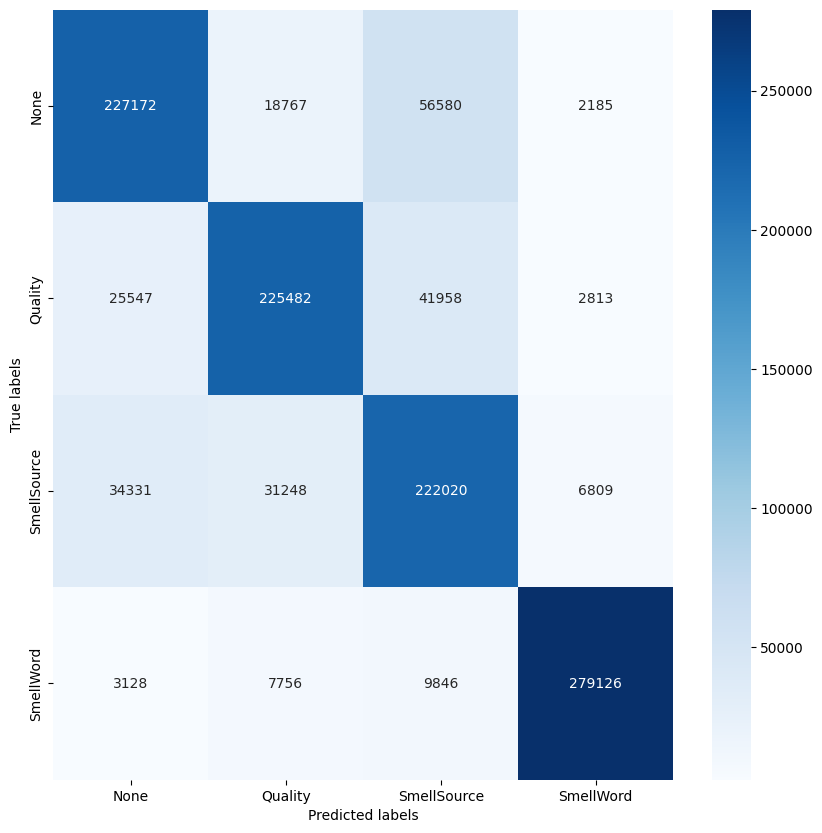

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(validation_labels_flat, predicted_labels_flat)

# Display the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

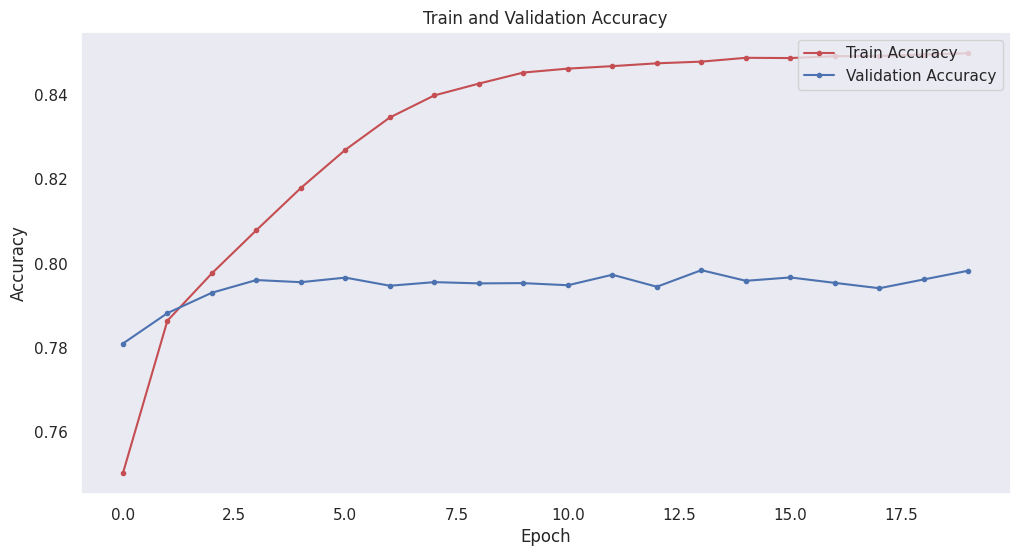

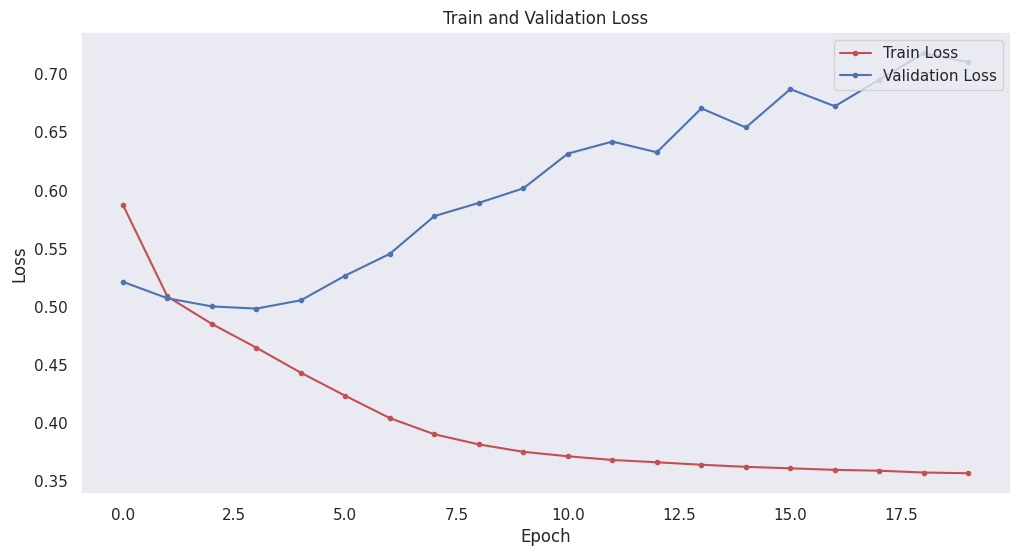

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(history.history)

# Plotting
sns.set()

# Accuracy
plt.figure(figsize=(12, 6))
plt.plot(hist_df["accuracy"],'r', marker='.', label="Train Accuracy")
plt.plot(hist_df["val_accuracy"],'b', marker='.', label="Validation Accuracy")
plt.title("Train and Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.grid()
plt.show()

# Loss
plt.figure(figsize=(12, 6))
plt.plot(hist_df["loss"],'r', marker='.', label="Train Loss")
plt.plot(hist_df["val_loss"],'b', marker='.', label="Validation Loss")
plt.title("Train and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid()
plt.show()

### **BERT large**

In [ ]:
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, TimeDistributed
from transformers import TFBertModel, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import Model
import pandas as pd
import numpy as np

# Mount your Google Drive
drive.mount('/content/drive')

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

# Placeholder column names replaced with actual column names
sentences = df_all_annotation['Token'].values

# Before applying SMOTE, you need to encode your labels to integer values
le = LabelEncoder()
df_all_annotation['Annotation_enc'] = le.fit_transform(df_all_annotation['Annotation'])
labels = df_all_annotation['Annotation_enc'].values

MAX_LEN = 24  # Set the maximum sequence length
num_labels = len(np.unique(labels))  # Number of unique labels

# Encode the sentences to embeddings
input_ids = [tokenizer.encode(sent, add_special_tokens=True, max_length=MAX_LEN, padding='max_length', truncation=True) for sent in sentences]

# Reshape input_ids
input_ids = np.array(input_ids)

# Apply SMOTE
smote = SMOTE(random_state=2023)
input_ids_res, labels_res = smote.fit_resample(input_ids, labels)

# Now, split the data into train and test sets
train_input_ids, validation_input_ids, train_labels, validation_labels = train_test_split(input_ids_res, labels_res, random_state=2020, test_size=0.1)

def encode_labels(labels, max_len):
    encoded_labels = []
    for label in labels:
        encoded_label = [label] * max_len  # Repeat the label for the length of the sentence
        encoded_label = encoded_label[:max_len]  # Truncate if necessary
        encoded_labels.append(encoded_label)
    return np.array(encoded_labels)

# Encode the labels
train_labels = encode_labels(train_labels, MAX_LEN)
validation_labels = encode_labels(validation_labels, MAX_LEN)

# Convert labels and inputs into tensorflow tensors
train_labels = tf.constant(train_labels)
validation_labels = tf.constant(validation_labels)
train_inputs = tf.constant(train_input_ids)
validation_inputs = tf.constant(validation_input_ids)

# Load the BERT model
bert_model = TFBertModel.from_pretrained("bert-large-uncased")

# Build the rest of the model
input_layer = Input(shape=(MAX_LEN,), dtype='int32')
bert_output = bert_model(input_layer)[0]
lstm_layer = Bidirectional(LSTM(units=512, return_sequences=True))(bert_output)
output_layer = TimeDistributed(Dense(num_labels, activation='softmax'))(lstm_layer)

# Construct the final model
model = Model(input_layer, output_layer)

# Optimizer, loss, and metric
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Training
history = model.fit(
    train_inputs, train_labels,
    validation_data=(validation_inputs, validation_labels),
    batch_size=256,
    epochs=20
)

# Save the weights of the model
model.save_weights('/content/drive/My Drive/bert_large_bilstm_multilabel_uncased/model_weights.h5')

# Save the config of the BERT model
bert_model.save_pretrained('/content/drive/My Drive/bert_large_bilstm_multilabel_uncased')

# Save the architecture of the whole model (except BERT) into a JSON file
model_json = model.to_json()
with open('/content/drive/My Drive/bert_large_bilstm_multilabel_uncased/model.json', 'w') as json_file:
    json_file.write(model_json)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/20


1751/1751 [==============================] - 718s 355ms/step - loss: 0.5804 - accuracy: 0.7537 - val_loss: 0.5307 - val_accuracy: 0.7811
Epoch 2/20
1751/1751 [==============================] - 607s 346ms/step - loss: 0.5023 - accuracy: 0.7901 - val_loss: 0.5039 - val_accuracy: 0.7895
Epoch 3/20
1751/1751 [==============================] - 606s 346ms/step - loss: 0.4752 - accuracy: 0.8027 - val_loss: 0.5091 - val_accuracy: 0.7932
Epoch 4/20
1751/1751 [==============================] - 606s 346ms/step - loss: 0.4492 - accuracy: 0.8149 - val_loss: 0.5056 - val_accuracy: 0.7941
Epoch 5/20
1751/1751 [==============================] - 606s 346ms/step - loss: 0.4226 - accuracy: 0.8268 - val_loss: 0.5353 - val_accuracy: 0.7972
Epoch 6/20
1751/1751 [==============================] - 605s 346ms/step - loss: 0.3983 - accuracy: 0.8365 - val_loss: 0.5914 - val_accuracy: 0.7956
Epoch 7/20
1751/1751 [==============================] - 605s 346ms/step - loss: 0.3832 - accuracy: 0.8418 - val_loss: 0.603

In [ ]:
from sklearn.metrics import classification_report

# Generate predictions
predictions = model.predict(validation_inputs)
predicted_labels = np.argmax(predictions, axis=2)

# Flatten the predictions
predicted_labels_flat = predicted_labels.flatten()

# Flatten the true labels
validation_labels_flat = validation_labels.numpy().flatten()

# Print classification report
print(classification_report(validation_labels_flat, predicted_labels_flat, target_names=le.classes_, digits=5))

1556/1556 [==============================] - 75s 44ms/step
              precision    recall  f1-score   support

        None    0.78193   0.74865   0.76493    304704
     Quality    0.80436   0.75159   0.77708    295800
 SmellSource    0.66800   0.75241   0.70770    294408
   SmellWord    0.94873   0.93347   0.94104    299856

    accuracy                        0.79669   1194768
   macro avg    0.80076   0.79653   0.79769   1194768
weighted avg    0.80127   0.79669   0.79803   1194768



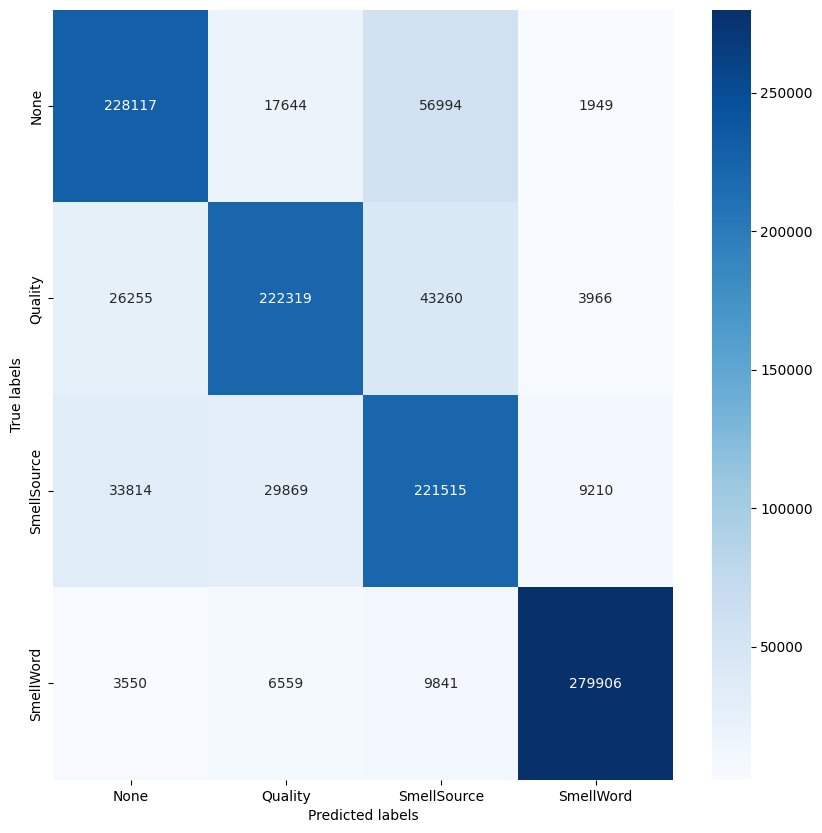

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(validation_labels_flat, predicted_labels_flat)

# Display the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

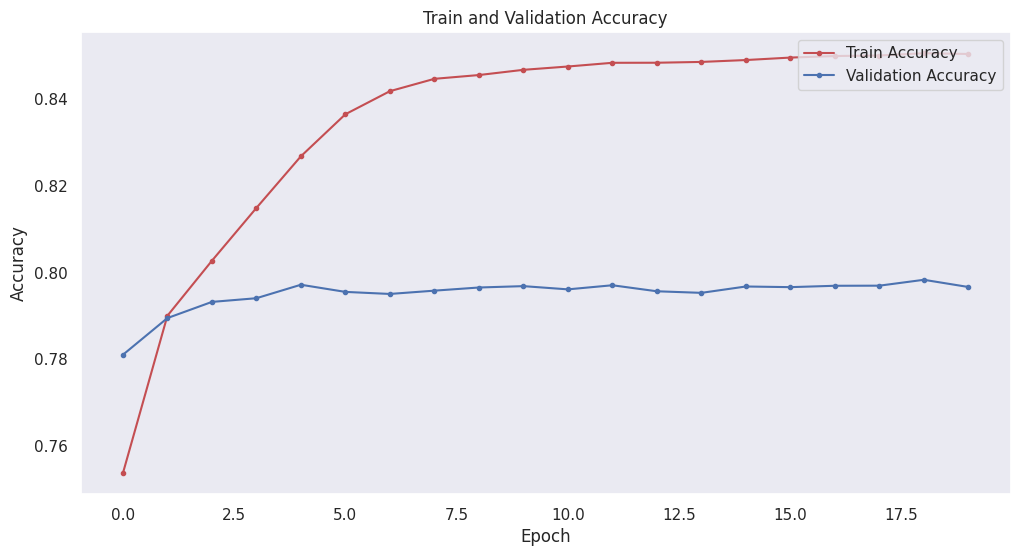

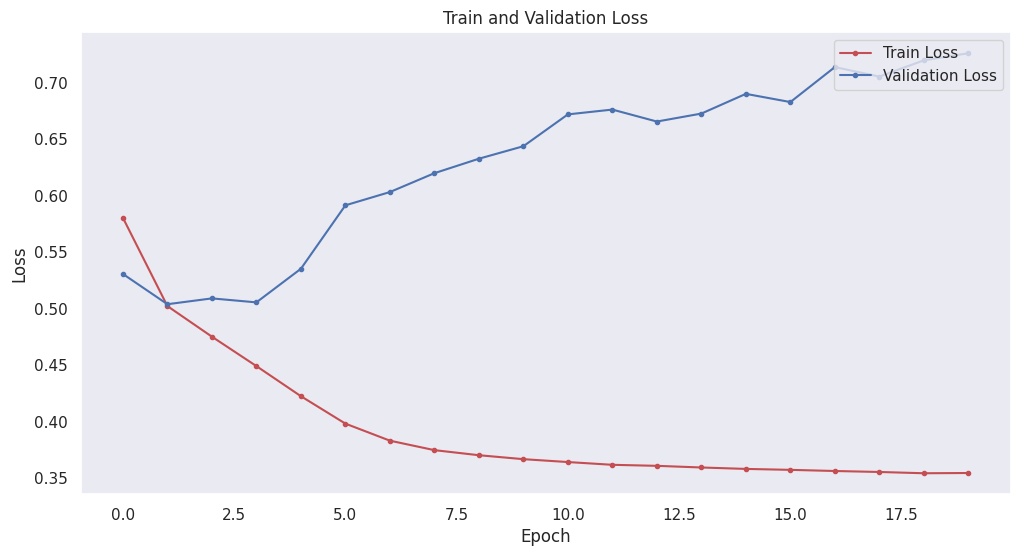

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(history.history)

# Plotting
sns.set()

# Accuracy
plt.figure(figsize=(12, 6))
plt.plot(hist_df["accuracy"],'r', marker='.', label="Train Accuracy")
plt.plot(hist_df["val_accuracy"],'b', marker='.', label="Validation Accuracy")
plt.title("Train and Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.grid()
plt.show()

# Loss
plt.figure(figsize=(12, 6))
plt.plot(hist_df["loss"],'r', marker='.', label="Train Loss")
plt.plot(hist_df["val_loss"],'b', marker='.', label="Validation Loss")
plt.title("Train and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid()
plt.show()

### **RoBERTa base**

In [ ]:
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, TimeDistributed
from transformers import TFRobertaModel, RobertaTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import Model
import pandas as pd
import numpy as np

# Mount your Google Drive
drive.mount('/content/drive')

# Initialize the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

# Placeholder column names replaced with actual column names
sentences = df_all_annotation['Token'].values

# Before applying SMOTE, you need to encode your labels to integer values
le = LabelEncoder()
df_all_annotation['Annotation_enc'] = le.fit_transform(df_all_annotation['Annotation'])
labels = df_all_annotation['Annotation_enc'].values

MAX_LEN = 24  # Set the maximum sequence length
num_labels = len(np.unique(labels))  # Number of unique labels

# Encode the sentences to embeddings
input_ids = [tokenizer.encode(sent, add_special_tokens=True, max_length=MAX_LEN, padding='max_length', truncation=True) for sent in sentences]

# Reshape input_ids
input_ids = np.array(input_ids)

# Apply SMOTE
smote = SMOTE(random_state=2023)
input_ids_res, labels_res = smote.fit_resample(input_ids, labels)

# Now, split the data into train and test sets
train_input_ids, validation_input_ids, train_labels, validation_labels = train_test_split(input_ids_res, labels_res, random_state=2020, test_size=0.1)

def encode_labels(labels, max_len):
    encoded_labels = []
    for label in labels:
        encoded_label = [label] * max_len  # Repeat the label for the length of the sentence
        encoded_label = encoded_label[:max_len]  # Truncate if necessary
        encoded_labels.append(encoded_label)
    return np.array(encoded_labels)

# Encode the labels
train_labels = encode_labels(train_labels, MAX_LEN)
validation_labels = encode_labels(validation_labels, MAX_LEN)

# Convert labels and inputs into tensorflow tensors
train_labels = tf.constant(train_labels)
validation_labels = tf.constant(validation_labels)
train_inputs = tf.constant(train_input_ids)
validation_inputs = tf.constant(validation_input_ids)

# Load the RoBERTa model
roberta_model = TFRobertaModel.from_pretrained("roberta-base")

# Build the rest of the model
input_layer = Input(shape=(MAX_LEN,), dtype='int32')
roberta_output = roberta_model(input_layer)[0]
lstm_layer = Bidirectional(LSTM(units=512, return_sequences=True))(roberta_output)
output_layer = TimeDistributed(Dense(num_labels, activation='softmax'))(lstm_layer)

# Construct the final model
model = Model(input_layer, output_layer)

# Optimizer, loss, and metric
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Training
history = model.fit(
    train_inputs, train_labels,
    validation_data=(validation_inputs, validation_labels),
    batch_size=256,
    epochs=20
)

import json

# Save the weights of the model
model.save_weights('/content/drive/My Drive/roberta_base_bilstm_multilabel_uncased/model_weights.h5')

# Save the config of the RoBERTa model
with open('/content/drive/My Drive/roberta_base_bilstm_multilabel_uncased/roberta_config.json', 'w') as f:
    json.dump(roberta_model.config.to_dict(), f)

# Save the architecture of the whole model (except RoBERTa) into a JSON file
model_json = model.to_json()
with open('/content/drive/My Drive/roberta_base_bilstm_multilabel_uncased/model.json', 'w') as json_file:
    json_file.write(model_json)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Epoch 1/20


1751/1751 [==============================] - 304s 145ms/step - loss: 0.4968 - accuracy: 0.7784 - val_loss: 0.4466 - val_accuracy: 0.7991
Epoch 2/20
1751/1751 [==============================] - 233s 133ms/step - loss: 0.4423 - accuracy: 0.8010 - val_loss: 0.4416 - val_accuracy: 0.8024
Epoch 3/20
1751/1751 [==============================] - 234s 134ms/step - loss: 0.4307 - accuracy: 0.8059 - val_loss: 0.4354 - val_accuracy: 0.8059
Epoch 4/20
1751/1751 [==============================] - 233s 133ms/step - loss: 0.4200 - accuracy: 0.8110 - val_loss: 0.4277 - val_accuracy: 0.8068
Epoch 5/20
1751/1751 [==============================] - 232s 133ms/step - loss: 0.4075 - accuracy: 0.8184 - val_loss: 0.4239 - val_accuracy: 0.8120
Epoch 6/20
1751/1751 [==============================] - 232s 133ms/step - loss: 0.3932 - accuracy: 0.8272 - val_loss: 0.4177 - val_accuracy: 0.8168
Epoch 7/20
1751/1751 [==============================] - 232s 133ms/step - loss: 0.3781 - accuracy: 0.8363 - val_loss: 0.421

In [ ]:
from sklearn.metrics import classification_report

# Generate predictions
predictions = model.predict(validation_inputs)
predicted_labels = np.argmax(predictions, axis=2)

# Flatten the predictions
predicted_labels_flat = predicted_labels.flatten()

# Flatten the true labels
validation_labels_flat = validation_labels.numpy().flatten()

# Print classification report
print(classification_report(validation_labels_flat, predicted_labels_flat, target_names=le.classes_, digits=5))

1556/1556 [==============================] - 39s 23ms/step
              precision    recall  f1-score   support

        None    0.87860   0.79216   0.83314    304704
     Quality    0.81042   0.77782   0.79378    295800
 SmellSource    0.67913   0.77738   0.72494    294408
   SmellWord    0.94651   0.94424   0.94537    299856

    accuracy                        0.82314   1194768
   macro avg    0.82866   0.82290   0.82431   1194768
weighted avg    0.82961   0.82314   0.82490   1194768



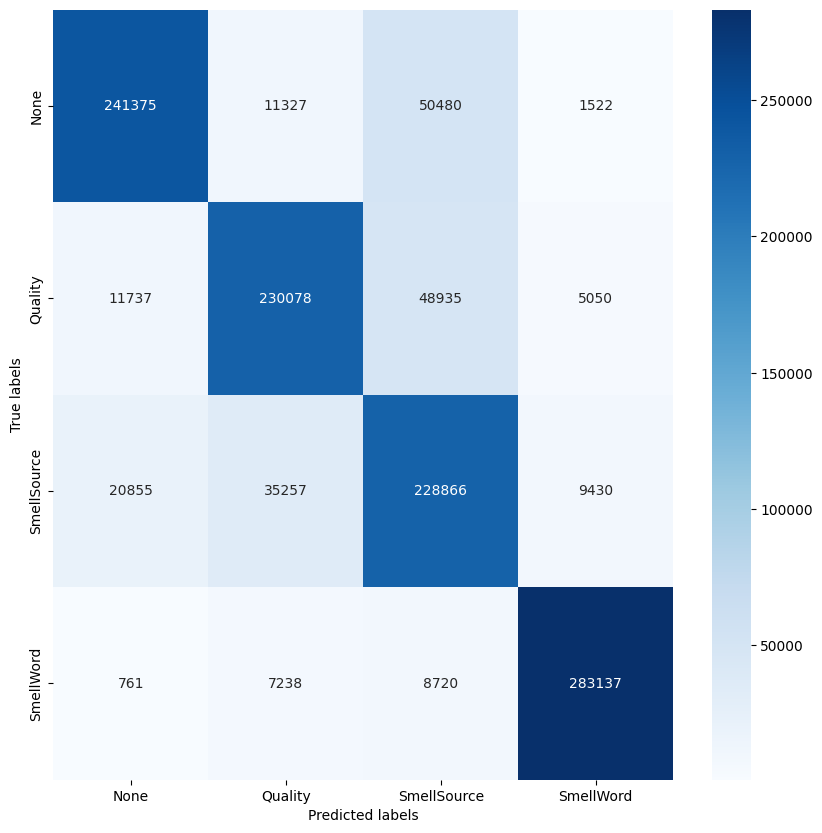

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(validation_labels_flat, predicted_labels_flat)

# Display the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

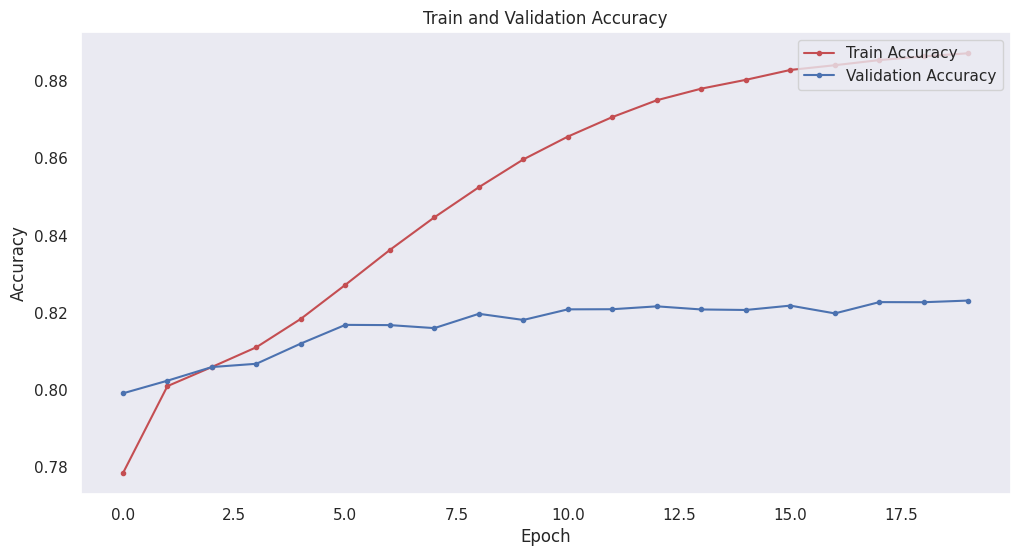

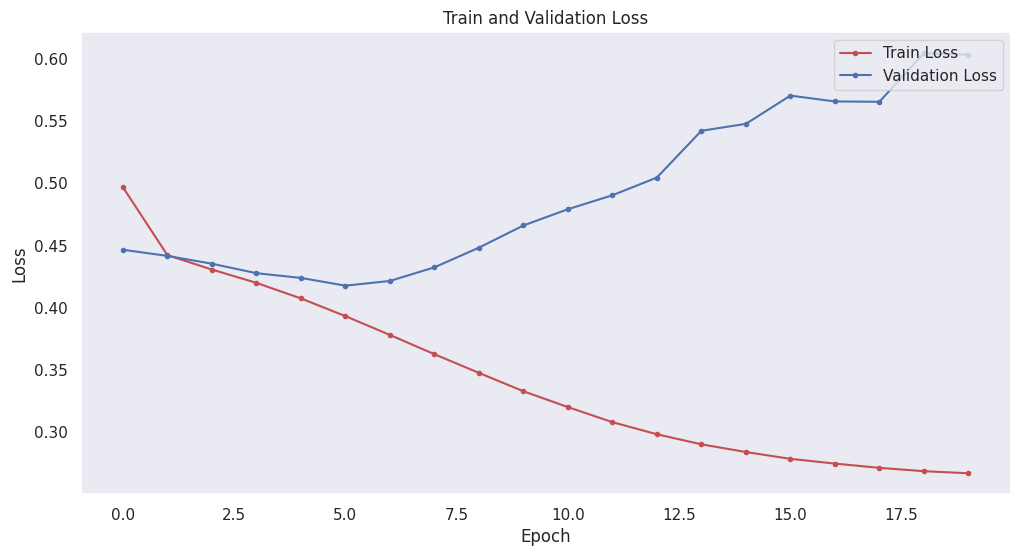

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(history.history)

# Plotting
sns.set()

# Accuracy
plt.figure(figsize=(12, 6))
plt.plot(hist_df["accuracy"],'r', marker='.', label="Train Accuracy")
plt.plot(hist_df["val_accuracy"],'b', marker='.', label="Validation Accuracy")
plt.title("Train and Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.grid()
plt.show()

# Loss
plt.figure(figsize=(12, 6))
plt.plot(hist_df["loss"],'r', marker='.', label="Train Loss")
plt.plot(hist_df["val_loss"],'b', marker='.', label="Validation Loss")
plt.title("Train and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid()
plt.show()

## **RoBERTa Large**

In [ ]:
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, TimeDistributed
from transformers import TFRobertaModel, RobertaTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import Model
import pandas as pd
import numpy as np

# Mount your Google Drive
drive.mount('/content/drive')

# Initialize the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-large', do_lower_case=True)

# Placeholder column names replaced with actual column names
sentences = df_all_annotation['Token'].values

# Before applying SMOTE, you need to encode your labels to integer values
le = LabelEncoder()
df_all_annotation['Annotation_enc'] = le.fit_transform(df_all_annotation['Annotation'])
labels = df_all_annotation['Annotation_enc'].values

MAX_LEN = 24  # Set the maximum sequence length
num_labels = len(np.unique(labels))  # Number of unique labels

# Encode the sentences to embeddings
input_ids = [tokenizer.encode(sent, add_special_tokens=True, max_length=MAX_LEN, padding='max_length', truncation=True) for sent in sentences]

# Reshape input_ids
input_ids = np.array(input_ids)

# Apply SMOTE
smote = SMOTE(random_state=2023)
input_ids_res, labels_res = smote.fit_resample(input_ids, labels)

# Now, split the data into train and test sets
train_input_ids, validation_input_ids, train_labels, validation_labels = train_test_split(input_ids_res, labels_res, random_state=2020, test_size=0.1)

def encode_labels(labels, max_len):
    encoded_labels = []
    for label in labels:
        encoded_label = [label] * max_len  # Repeat the label for the length of the sentence
        encoded_label = encoded_label[:max_len]  # Truncate if necessary
        encoded_labels.append(encoded_label)
    return np.array(encoded_labels)

# Encode the labels
train_labels = encode_labels(train_labels, MAX_LEN)
validation_labels = encode_labels(validation_labels, MAX_LEN)

# Convert labels and inputs into tensorflow tensors
train_labels = tf.constant(train_labels)
validation_labels = tf.constant(validation_labels)
train_inputs = tf.constant(train_input_ids)
validation_inputs = tf.constant(validation_input_ids)

# Load the RoBERTa model
roberta_model = TFRobertaModel.from_pretrained("roberta-large")

# Build the rest of the model
input_layer = Input(shape=(MAX_LEN,), dtype='int32')
roberta_output = roberta_model(input_layer)[0]
lstm_layer = Bidirectional(LSTM(units=512, return_sequences=True))(roberta_output)
output_layer = TimeDistributed(Dense(num_labels, activation='softmax'))(lstm_layer)

# Construct the final model
model = Model(input_layer, output_layer)

# Optimizer, loss, and metric
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Training
history = model.fit(
    train_inputs, train_labels,
    validation_data=(validation_inputs, validation_labels),
    batch_size=256,
    epochs=20
)

import json

# Save the weights and configuration of the RoBERTa model
roberta_model.save_pretrained('/content/drive/My Drive/roberta_large_bilstm_multilabel_uncased')

# Save the config of the RoBERTa model
config_dict = roberta_model.config.to_dict()
with open('/content/drive/My Drive/roberta_large_bilstm_multilabel_uncased/roberta_config.json', 'w') as f:
    json.dump(config_dict, f)

# Save the architecture of the whole model (except RoBERTa) into a JSON file
model_json = roberta_model.to_json()
with open('/content/drive/My Drive/roberta_large_bilstm_multilabel_uncased/model.json', 'w') as json_file:
    json_file.write(model_json)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Epoch 1/20


1751/1751 [==============================] - 719s 356ms/step - loss: 0.4964 - accuracy: 0.7782 - val_loss: 0.4433 - val_accuracy: 0.7949
Epoch 2/20
1751/1751 [==============================] - 609s 348ms/step - loss: 0.4455 - accuracy: 0.7994 - val_loss: 0.4489 - val_accuracy: 0.7989
Epoch 3/20
1751/1751 [==============================] - 609s 348ms/step - loss: 0.4417 - accuracy: 0.7999 - val_loss: 0.4417 - val_accuracy: 0.7997
Epoch 4/20
1751/1751 [==============================] - 609s 348ms/step - loss: 0.4256 - accuracy: 0.8063 - val_loss: 0.4374 - val_accuracy: 0.8059
Epoch 5/20
1751/1751 [==============================] - 609s 348ms/step - loss: 0.4230 - accuracy: 0.8076 - val_loss: 0.4288 - val_accuracy: 0.8080
Epoch 6/20
1751/1751 [==============================] - 608s 348ms/step - loss: 0.4082 - accuracy: 0.8137 - val_loss: 0.4318 - val_accuracy: 0.8101
Epoch 7/20
1751/1751 [==============================] - 609s 348ms/step - loss: 0.4001 - accuracy: 0.8194 - val_loss: 0.428

In [ ]:
from sklearn.metrics import classification_report

# Generate predictions
predictions = model.predict(validation_inputs)
predicted_labels = np.argmax(predictions, axis=2)

# Flatten the predictions
predicted_labels_flat = predicted_labels.flatten()

# Flatten the true labels
validation_labels_flat = validation_labels.numpy().flatten()

# Print classification report
print(classification_report(validation_labels_flat, predicted_labels_flat, target_names=le.classes_, digits=5))

1556/1556 [==============================] - 77s 45ms/step
              precision    recall  f1-score   support

        None    0.88123   0.78940   0.83279    304704
     Quality    0.83286   0.75514   0.79210    295800
 SmellSource    0.67066   0.80327   0.73100    294408
   SmellWord    0.94316   0.94676   0.94496    299856

    accuracy                        0.82383   1194768
   macro avg    0.83198   0.82364   0.82521   1194768
weighted avg    0.83291   0.82383   0.82578   1194768



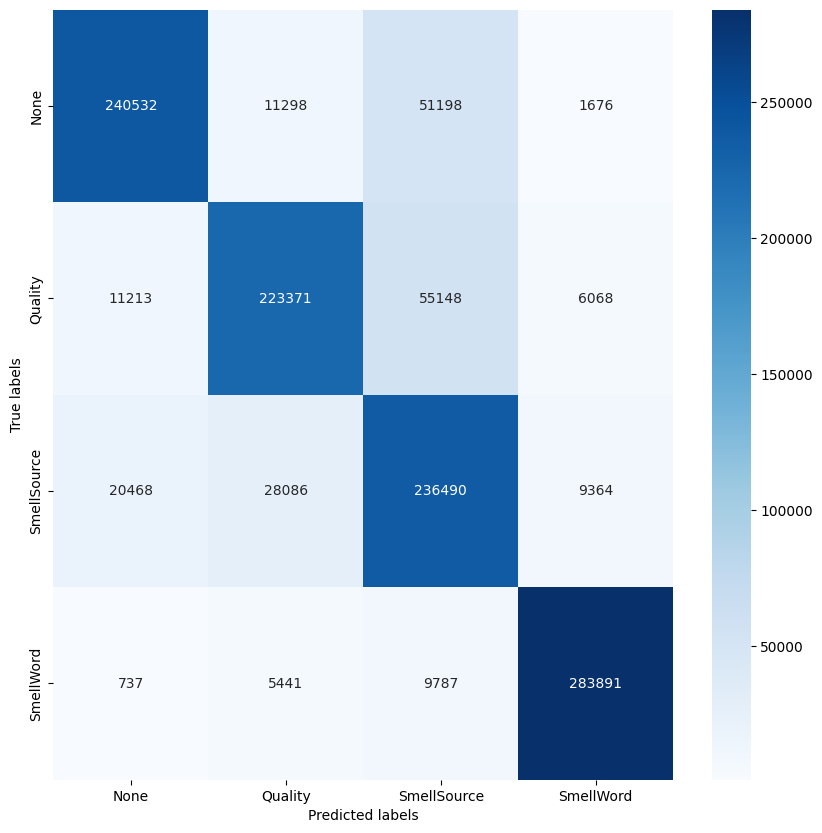

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(validation_labels_flat, predicted_labels_flat)

# Display the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

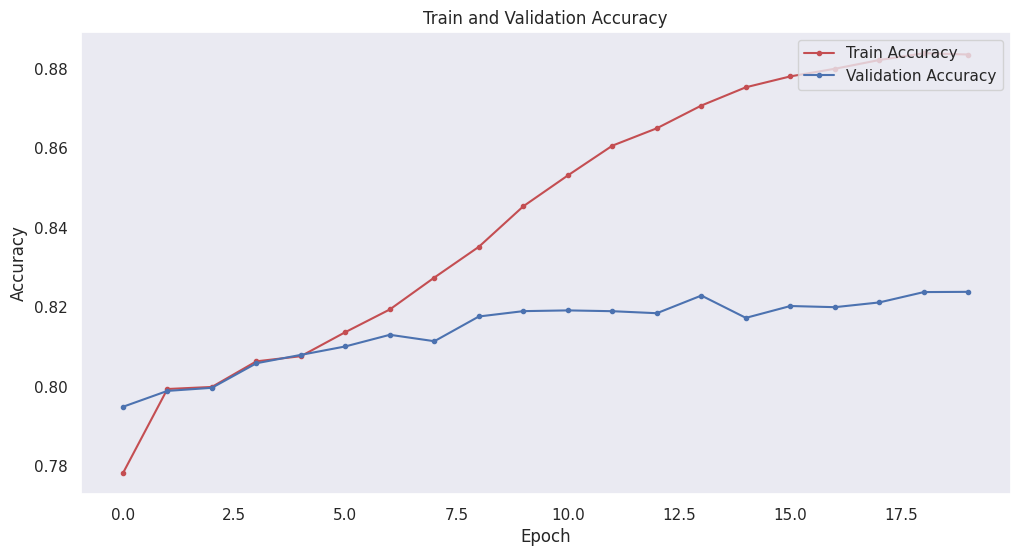

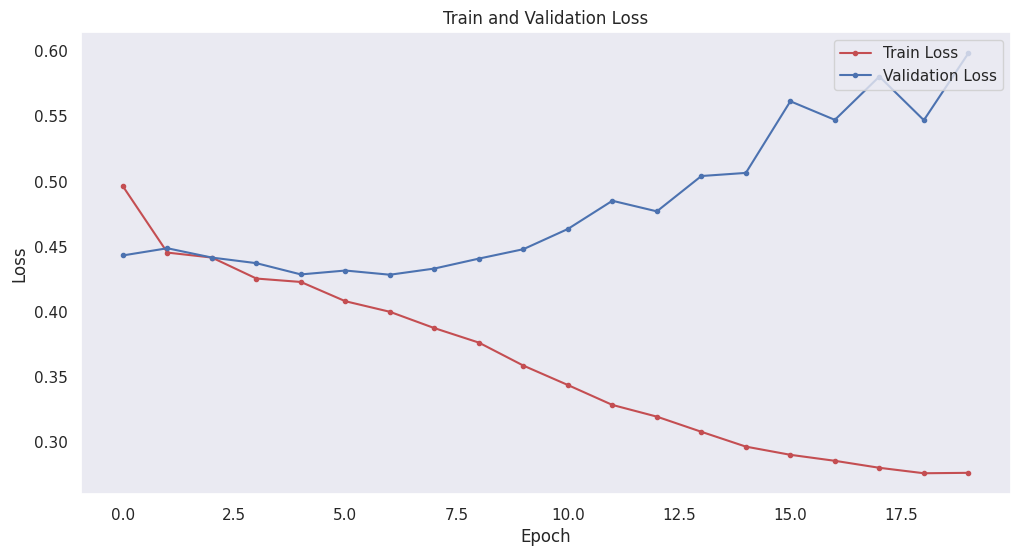

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(history.history)

# Plotting
sns.set()

# Accuracy
plt.figure(figsize=(12, 6))
plt.plot(hist_df["accuracy"],'r', marker='.', label="Train Accuracy")
plt.plot(hist_df["val_accuracy"],'b', marker='.', label="Validation Accuracy")
plt.title("Train and Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.grid()
plt.show()

# Loss
plt.figure(figsize=(12, 6))
plt.plot(hist_df["loss"],'r', marker='.', label="Train Loss")
plt.plot(hist_df["val_loss"],'b', marker='.', label="Validation Loss")
plt.title("Train and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid()
plt.show()

### **MacBERTh**

In [ ]:
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, TimeDistributed
from transformers import TFBertForTokenClassification, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import pandas as pd
import numpy as np

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Use MacBERT tokenizer
tokenizer = BertTokenizer.from_pretrained('emanjavacas/MacBERTh', do_lower_case=True)

# Retrieve sentences from dataframe
sentences = df_all_annotation['Token'].values

# Encode labels before applying SMOTE
le = LabelEncoder()
df_all_annotation['Annotation_enc'] = le.fit_transform(df_all_annotation['Annotation'])
labels = df_all_annotation['Annotation_enc'].values

MAX_LEN = 24  # Define maximum sequence length
num_labels = len(np.unique(labels))  # Determine number of unique labels

# Encode sentences to embeddings
input_ids = [tokenizer.encode(sent, add_special_tokens=True, max_length=MAX_LEN, padding='max_length', truncation=True) for sent in sentences]

# Reshape input_ids
input_ids = np.array(input_ids)

# Apply SMOTE
smote = SMOTE(random_state=2023)
input_ids_res, labels_res = smote.fit_resample(input_ids, labels)

# Split the data into training and validation sets
train_input_ids, validation_input_ids, train_labels, validation_labels = train_test_split(input_ids_res, labels_res, random_state=2020, test_size=0.1)

def encode_labels(labels, max_len):
    encoded_labels = []
    for label in labels:
        encoded_label = [label] * max_len
        encoded_label = encoded_label[:max_len]
        encoded_labels.append(encoded_label)
    return np.array(encoded_labels)

# Encode labels
train_labels = encode_labels(train_labels, MAX_LEN)
validation_labels = encode_labels(validation_labels, MAX_LEN)

# Convert labels and inputs into tensorflow tensors
train_labels = tf.constant(train_labels)
validation_labels = tf.constant(validation_labels)
train_inputs = tf.constant(train_input_ids)
validation_inputs = tf.constant(validation_input_ids)

# Load MacBERT model
macberth_model = TFBertForTokenClassification.from_pretrained('emanjavacas/MacBERTh', num_labels=num_labels, from_pt=True)

# Define optimizer, loss, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

macberth_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train the model
history = macberth_model.fit(
    train_inputs, train_labels,
    validation_data=(validation_inputs, validation_labels),
    batch_size=256,
    epochs=20
)

# Save model to Google Drive
macberth_model.save_pretrained('/content/drive/My Drive/macberth_bilstm_multilabel_uncased')

# Save tokenizer to Google Drive
tokenizer.save_pretrained('/content/drive/My Drive/macberth_bilstm_multilabel_uncased')

# Save the configuration of the model to Google Drive
macberth_model.config.to_json_file('/content/drive/My Drive/macberth_bilstm_multilabel_uncased/config.json')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForTokenClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForTokenClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForTokenClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20
1751/1751 [==============================] - 289s 137ms/step - loss: 0.5583 - accuracy: 0.7606 - val_loss: 0.5031 - val_accuracy: 0.7854
Epoch 2/20
1751/1751 [==============================] - 224s 128ms/step - loss: 0.4878 - accuracy: 0.7930 - val_loss: 0.4819 - val_accuracy: 0.7978
Epoch 3/20
1751/1751 [==============================] - 223s 127ms/step - loss: 0.4625 - accuracy: 0.8065 - val_loss: 0.4738 - val_accuracy: 0.8012
Epoch 4/20
1751/1751 [==============================] - 223s 127ms/step - loss: 0.4399 - accuracy: 0.8177 - val_loss: 0.4731 - val_accuracy: 0.8070
Epoch 5/20
1751/1751 [==============================] - 223s 127ms/step - loss: 0.4189 - accuracy: 0.8272 - val_loss: 0.4799 - val_accuracy: 0.8046
Epoch 6/20
1751/1751 [==============================] - 223s 127ms/step - loss: 0.4000 - accuracy: 0.8349 - val_loss: 0.4938 - val_accuracy: 0.8056
Epoch 7/20
1751/1751 [==============================] - 222s 127ms/step - loss: 0.3829 - accuracy: 0.8418 - val_

In [ ]:
from sklearn.metrics import classification_report

# Predicting on our validation set
validation_predictions = macberth_model.predict(validation_inputs)

# Reshape predictions
validation_predictions = np.argmax(validation_predictions.logits, axis=-1)

# Also, reshape validation labels to the same shape as predictions
validation_labels_reshaped = validation_labels.numpy().reshape(-1)

# Mask out the extra tokens
mask = validation_inputs.numpy().flatten() != 0
validation_predictions_masked = validation_predictions.flatten()[mask]
validation_labels_masked = validation_labels_reshaped[mask]

# Print the classification report
print(classification_report(validation_labels_masked, validation_predictions_masked, digits=5))

1556/1556 [==============================] - 35s 22ms/step
              precision    recall  f1-score   support

           0    0.79114   0.77651   0.78376     39528
           1    0.83611   0.74466   0.78774     41043
           2    0.69160   0.79519   0.73979     42767
           3    0.96171   0.93566   0.94850     43781

    accuracy                        0.81516    167119
   macro avg    0.82014   0.81301   0.81495    167119
weighted avg    0.82140   0.81516   0.81664    167119



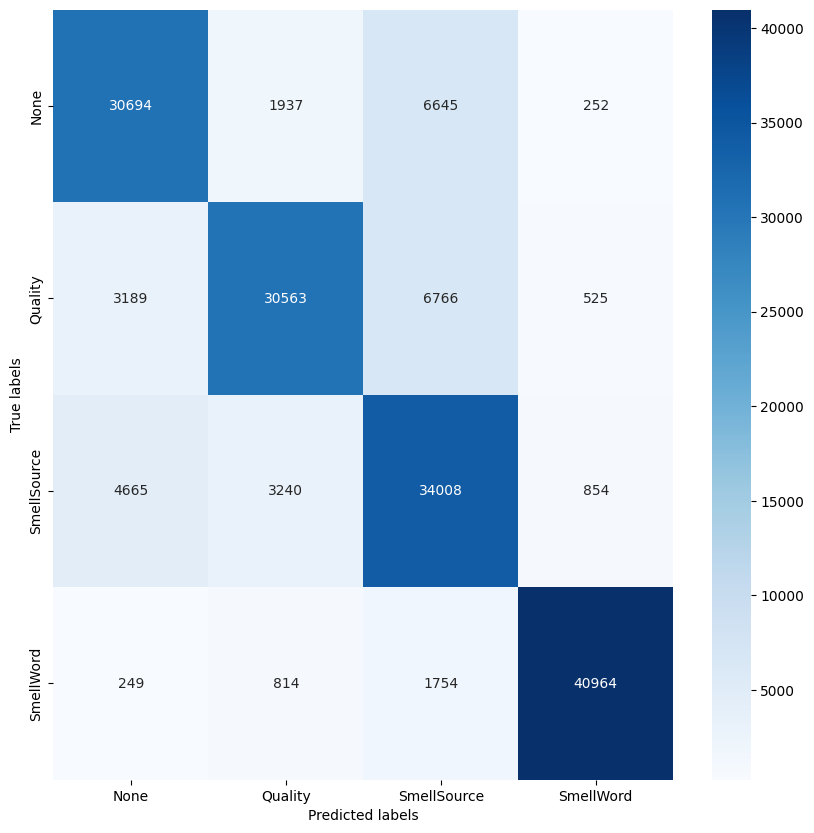

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(validation_labels_masked, validation_predictions_masked)

# Display the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

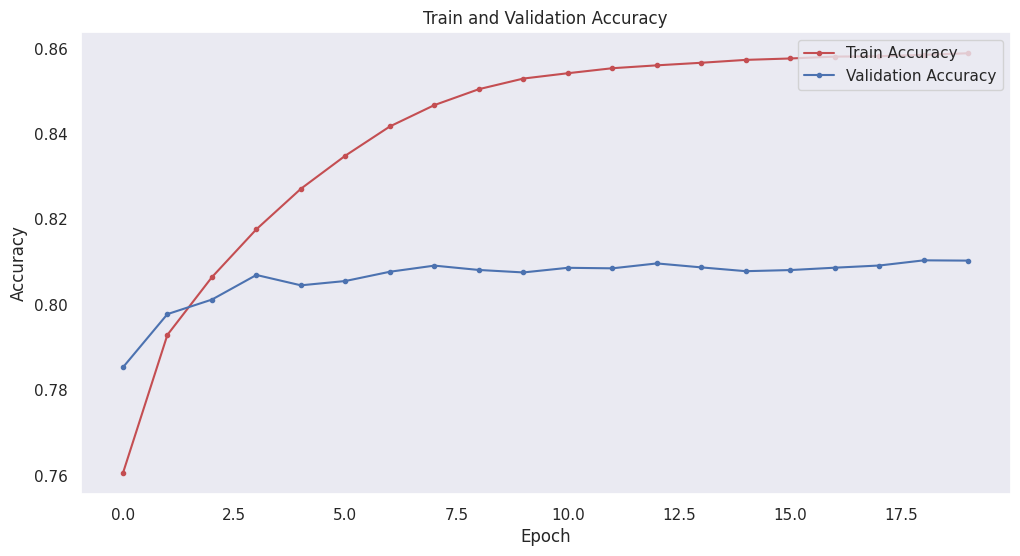

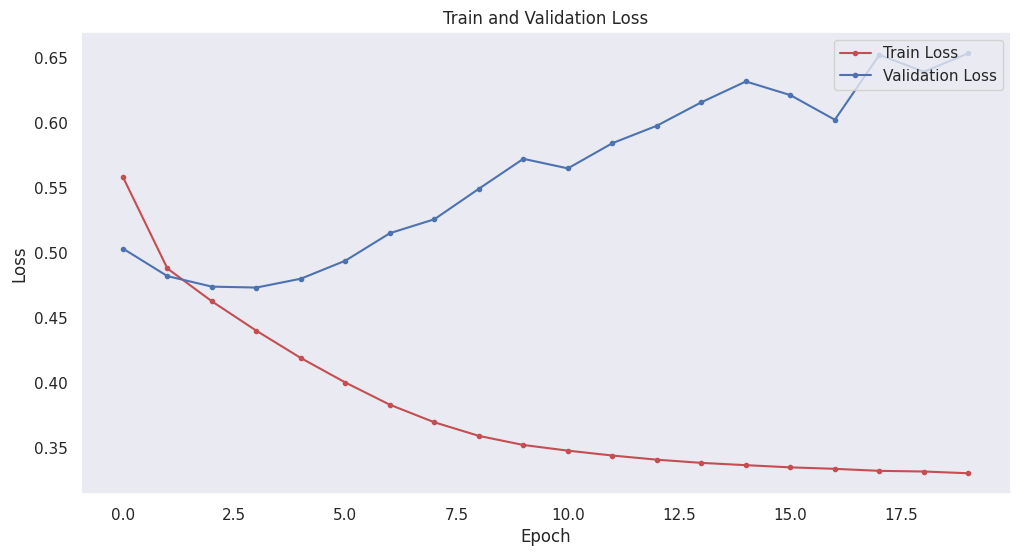

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(history.history)

# Plotting
sns.set()

# Accuracy
plt.figure(figsize=(12, 6))
plt.plot(hist_df["accuracy"],'r', marker='.', label="Train Accuracy")
plt.plot(hist_df["val_accuracy"],'b', marker='.', label="Validation Accuracy")
plt.title("Train and Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.grid()
plt.show()

# Loss
plt.figure(figsize=(12, 6))
plt.plot(hist_df["loss"],'r', marker='.', label="Train Loss")
plt.plot(hist_df["val_loss"],'b', marker='.', label="Validation Loss")
plt.title("Train and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid()
plt.show()

#**Testing models on manually labeled data**

In [ ]:
import pandas as pd

# First, mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load new data
data_path = '/content/drive/My Drive/df_exploded.csv'  # Please adjust the path if necessary
df_new = pd.read_csv(data_path)

Mounted at /content/drive


In [ ]:
df_all_annotation.Annotation.unique()

NameError: ignored

In [ ]:
df_new['TAGS'].fillna('None', inplace=True)

In [ ]:
df_new['TAGS'] = df_new['TAGS'].replace({
    'SmellQuality': 'Quality'
})

In [ ]:
df_new.TAGS.unique()

array(['None', 'Quality', 'SmellWord', 'SmellSource'], dtype=object)

In [ ]:
df_new

,Unnamed: 0,title,tag,artist,year,lyrics,decade,Contains Profanity,lyrics_sentences,lyrics_sentences_1,contains_word,found_words,found_sentences,smell_event,index_column,token,start,end,TAGS
0,2058339,A Strange Perfume,rock,Membranes,2019,Hypnotised by the heaven scent.A strange perfu...,2010,False,"['Hypnotised by the heaven scent.', 'A strange...","['Hypnotised by the heaven scent.', 'A strange...",1,"['scent', 'perfume', 'perfume', 'perfume', 'fr...","['hypnotised by the heaven scent', 'a strange ...",1,2006,hypnotised,0,9,None
1,2058339,A Strange Perfume,rock,Membranes,2019,Hypnotised by the heaven scent.A strange perfu...,2010,False,"['Hypnotised by the heaven scent.', 'A strange...","['Hypnotised by the heaven scent.', 'A strange...",1,"['scent', 'perfume', 'perfume', 'perfume', 'fr...","['hypnotised by the heaven scent', 'a strange ...",1,2006,by,11,12,None
2,2058339,A Strange Perfume,rock,Membranes,2019,Hypnotised by the heaven scent.A strange perfu...,2010,False,"['Hypnotised by the heaven scent.', 'A strange...","['Hypnotised by the heaven scent.', 'A strange...",1,"['scent', 'perfume', 'perfume', 'perfume', 'fr...","['hypnotised by the heaven scent', 'a strange ...",1,2006,the,14,16,None
3,2058339,A Strange Perfume,rock,Membranes,2019,Hypnotised by the heaven scent.A strange perfu...,2010,False,"['Hypnotised by the heaven scent.', 'A strange...","['Hypnotised by the heaven scent.', 'A strange...",1,"['scent', 'perfume', 'perfume', 'perfume', 'fr...","['hypnotised by the heaven scent', 'a strange ...",1,2006,heaven,18,23,Quality
4,2058339,A Strange Perfume,rock,Membranes,2019,Hypnotised by the heaven scent.A strange perfu...,2010,False,"['Hypnotised by the heaven scent.', 'A strange...","['Hypnotised by the heaven scent.', 'A strange...",1,"['scent', 'perfume', 'perfume', 'perfume', 'fr...","['hypnotised by the heaven scent', 'a strange ...",1,2006,scent,25,30,SmellWord
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56128,1470822,Rapt: In The Evening Air,rap,Art of Noise,1999,".Winter and summer, Debussy used to work surro...",1990,False,"['.Winter and summer, Debussy used to work sur...","['.Winter and summer, Debussy used to work sur...",1,"['perfume', 'perfume', 'perfume', 'perfume', '...",['it would remind you of the line of baudelair...,1,216,swirl,970,974,None
56129,1470822,Rapt: In The Evening Air,rap,Art of Noise,1999,".Winter and summer, Debussy used to work surro...",1990,False,"['.Winter and summer, Debussy used to work sur...","['.Winter and summer, Debussy used to work sur...",1,"['perfume', 'perfume', 'perfume', 'perfume', '...",['it would remind you of the line of baudelair...,1,216,in,976,977,None
56130,1470822,Rapt: In The Evening Air,rap,Art of Noise,1999,".Winter and summer, Debussy used to work surro...",1990,False,"['.Winter and summer, Debussy used to work sur...","['.Winter and summer, Debussy used to work sur...",1,"['perfume', 'perfume', 'perfume', 'perfume', '...",['it would remind you of the line of baudelair...,1,216,the,979,981,None
56131,1470822,Rapt: In The Evening Air,rap,Art of Noise,1999,".Winter and summer, Debussy used to work surro...",1990,False,"['.Winter and summer, Debussy used to work sur...","['.Winter and summer, Debussy used to work sur...",1,"['perfume', 'perfume', 'perfume', 'perfume', '...",['it would remind you of the line of baudelair...,1,216,evening,983,989,None


In [ ]:
mode_value = df_new['token'].mode()
print(mode_value)

0    the
Name: token, dtype: object


In [ ]:
# Remove rows with NaN in the 'token' column
df_new = df_new.dropna(subset=['token'])

## **BERT base**

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.models import model_from_json
import tensorflow as tf
from google.colab import drive
import gdown
from tensorflow.keras.layers import Input

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Load the BERT model
bert_model = TFBertModel.from_pretrained('/content/drive/My Drive/bert_base_bilstm_multilabel_uncased')

# Load the JSON file that contains the model's architecture
with open('/content/drive/My Drive/bert_base_bilstm_multilabel_uncased/model.json', 'r') as json_file:
    json_savedModel = json_file.read()

# Recreate the model from its architecture and weights
model = model_from_json(json_savedModel, custom_objects={'TFBertModel': TFBertModel})
model.load_weights('/content/drive/My Drive/bert_base_bilstm_multilabel_uncased/model_weights.h5')

# Assume you have a pandas DataFrame 'df_new' that contains your new data
sentences = df_new['token'].values

# Create a label encoder
le = LabelEncoder()

# Fit the encoder and transform labels to integers
labels = le.fit_transform(df_new['TAGS'].values)

MAX_LEN = 24

# Function to encode labels
def encode_labels(labels, max_len):
    encoded_labels = []
    for label in labels:
        encoded_label = [label] * max_len  # Repeat the label for the length of the sentence
        encoded_label = encoded_label[:max_len]  # Truncate if necessary
        encoded_labels.append(encoded_label)
    return np.array(encoded_labels)

# Now you can tokenize the sentences
inputs = tokenizer(sentences.tolist(), padding='max_length', truncation=True, max_length=MAX_LEN, return_tensors='tf')

# Encode the labels
labels = encode_labels(labels, MAX_LEN)

# Convert labels into tensorflow tensors
labels = tf.constant(labels)

# Optimizer, loss, and metric
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Evaluate the model on the new dataset
evaluation = model.evaluate(inputs['input_ids'], labels)

print('Evaluation results: ', evaluation)

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at /content/drive/My Drive/bert_base_bilstm_multilabel_uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


1742/1742 [==============================] - 51s 27ms/step - loss: 1.0712 - accuracy: 0.7075
Evaluation results:  [1.0711654424667358, 0.7075498104095459]


1742/1742 [==============================] - 48s 25ms/step
              precision    recall  f1-score   support

        None    0.98307   0.71348   0.82685   1288608
     Quality    0.02004   0.60747   0.03880      4392
 SmellSource    0.04007   0.32478   0.07134     28752
   SmellWord    0.41479   0.94841   0.57716     15816

    accuracy                        0.70755   1337568
   macro avg    0.36449   0.64853   0.37854   1337568
weighted avg    0.95292   0.70755   0.80507   1337568



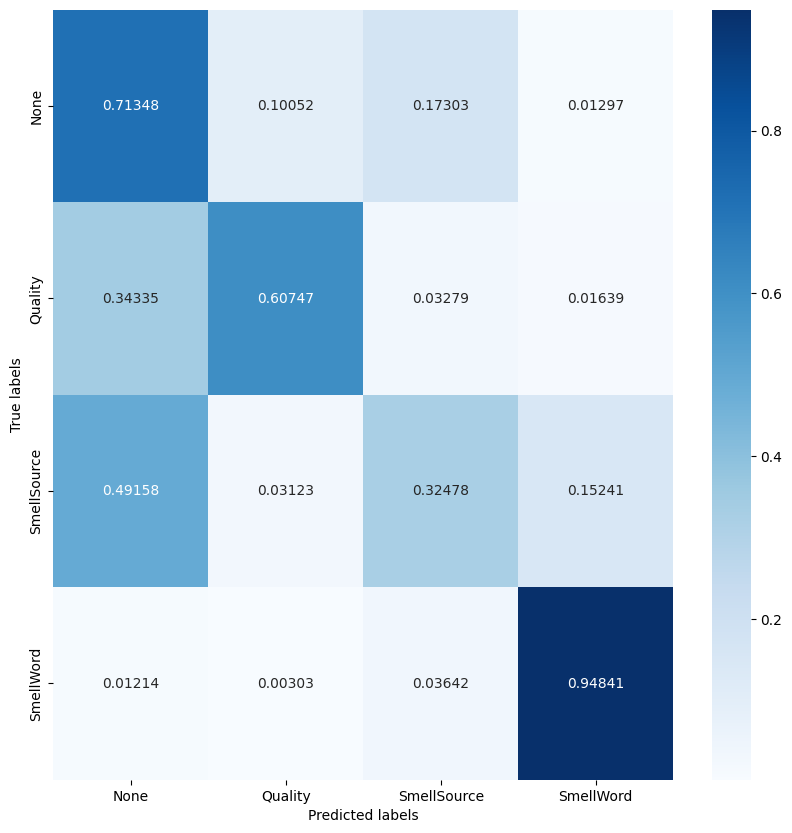

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Generate predictions
predictions = model.predict(inputs['input_ids'])
predicted_labels = np.argmax(predictions, axis=2)

# Flatten the predictions and true labels
predicted_labels_flat = predicted_labels.flatten()
labels_flat = labels.numpy().flatten()

# Print classification report with 5 decimal places
print(classification_report(labels_flat, predicted_labels_flat, target_names=le.classes_, digits=5))

# Compute the confusion matrix
cm = confusion_matrix(labels_flat, predicted_labels_flat, labels=np.unique(labels_flat))

# Normalize the confusion matrix for displaying ratios in the heatmap
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Display the confusion matrix as a heatmap with ratios
plt.figure(figsize=(10,10))
sns.heatmap(cm_norm, annot=True, fmt='.5f', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## **BERT large**

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.models import model_from_json
import tensorflow as tf
from google.colab import drive
import gdown
from tensorflow.keras.layers import Input

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

# Load the BERT model
bert_model = TFBertModel.from_pretrained('/content/drive/My Drive/bert_large_bilstm_multilabel_uncased')

# Load the JSON file that contains the model's architecture
with open('/content/drive/My Drive/bert_large_bilstm_multilabel_uncased/model.json', 'r') as json_file:
    json_savedModel = json_file.read()

# Recreate the model from its architecture and weights
model = model_from_json(json_savedModel, custom_objects={'TFBertModel': TFBertModel})
model.load_weights('/content/drive/My Drive/bert_large_bilstm_multilabel_uncased/model_weights.h5')

# Assume you have a pandas DataFrame 'df_new' that contains your new data
sentences = df_new['token'].values

# Create a label encoder
le = LabelEncoder()

# Fit the encoder and transform labels to integers
labels = le.fit_transform(df_new['TAGS'].values)

MAX_LEN = 24

# Function to encode labels
def encode_labels(labels, max_len):
    encoded_labels = []
    for label in labels:
        encoded_label = [label] * max_len  # Repeat the label for the length of the sentence
        encoded_label = encoded_label[:max_len]  # Truncate if necessary
        encoded_labels.append(encoded_label)
    return np.array(encoded_labels)

# Now you can tokenize the sentences
inputs = tokenizer(sentences.tolist(), padding='max_length', truncation=True, max_length=MAX_LEN, return_tensors='tf')

# Encode the labels
labels = encode_labels(labels, MAX_LEN)

# Convert labels into tensorflow tensors
labels = tf.constant(labels)

# Optimizer, loss, and metric
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Evaluate the model on the new dataset
evaluation = model.evaluate(inputs['input_ids'], labels)

print('Evaluation results: ', evaluation)

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at /content/drive/My Drive/bert_large_bilstm_multilabel_uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


1742/1742 [==============================] - 91s 49ms/step - loss: 1.0730 - accuracy: 0.7178
Evaluation results:  [1.0729619264602661, 0.7178259491920471]


1742/1742 [==============================] - 87s 46ms/step
              precision    recall  f1-score   support

        None    0.98318   0.72407   0.83396   1288608
     Quality    0.02069   0.59335   0.03999      4392
 SmellSource    0.04139   0.33024   0.07356     28752
   SmellWord    0.45163   0.94841   0.61188     15816

    accuracy                        0.71783   1337568
   macro avg    0.37422   0.64902   0.38985   1337568
weighted avg    0.95349   0.71783   0.81238   1337568



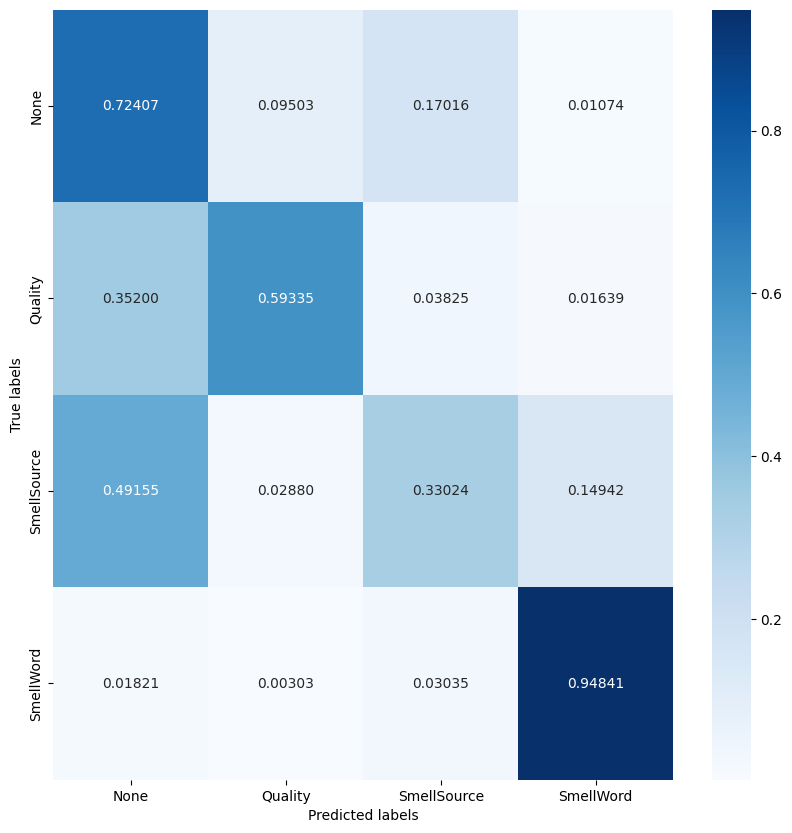

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Generate predictions
predictions = model.predict(inputs['input_ids'])
predicted_labels = np.argmax(predictions, axis=2)

# Flatten the predictions and true labels
predicted_labels_flat = predicted_labels.flatten()
labels_flat = labels.numpy().flatten()

# Print classification report
print(classification_report(labels_flat, predicted_labels_flat, target_names=le.classes_, digits=5))

# Compute the confusion matrix
cm = confusion_matrix(labels_flat, predicted_labels_flat, labels=np.unique(labels_flat))

# Normalize the confusion matrix for better contrast per label
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Display the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_norm, annot=True, fmt='.5f', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## **RoBERTa base**

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from transformers import RobertaTokenizer, TFRobertaModel
import tensorflow as tf
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

# Load the JSON file that contains the model's architecture
with open('/content/drive/My Drive/roberta_base_bilstm_multilabel_uncased/model.json', 'r') as json_file:
    json_savedModel = json_file.read()

# Recreate the model from its architecture
model = model_from_json(json_savedModel, custom_objects={'TFRobertaModel': TFRobertaModel})

# Load the weights into the model
model.load_weights('/content/drive/My Drive/roberta_base_bilstm_multilabel_uncased/model_weights.h5')

# Assume you have a pandas DataFrame 'df_new' that contains your new data
sentences = df_new['token'].values

# Create a label encoder
le = LabelEncoder()

# Fit the encoder and transform labels to integers
labels = le.fit_transform(df_new['TAGS'].values)

MAX_LEN = 24

# Function to encode labels
def encode_labels(labels, max_len):
    encoded_labels = []
    for label in labels:
        encoded_label = [label] * max_len  # Repeat the label for the length of the sentence
        encoded_label = encoded_label[:max_len]  # Truncate if necessary
        encoded_labels.append(encoded_label)
    return np.array(encoded_labels)

# Now you can tokenize the sentences
inputs = tokenizer(sentences.tolist(), padding='max_length', truncation=True, max_length=MAX_LEN, return_tensors='tf')

# Encode the labels
labels = encode_labels(labels, MAX_LEN)

# Convert labels into tensorflow tensors
labels = tf.constant(labels)

# Optimizer, loss, and metric
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Evaluate the model on the new dataset
evaluation = model.evaluate(inputs['input_ids'], labels)

print('Evaluation results: ', evaluation)

1742/1742 [==============================] - 48s 25ms/step - loss: 0.9128 - accuracy: 0.8336
Evaluation results:  [0.9128125309944153, 0.8336032032966614]


1742/1742 [==============================] - 46s 24ms/step
              precision    recall  f1-score   support

        None    0.98431   0.84484   0.90926   1288608
     Quality    0.05452   0.56284   0.09941      4392
 SmellSource    0.05643   0.30885   0.09542     28752
   SmellWord    0.51949   0.94689   0.67091     15816

    accuracy                        0.83360   1337568
   macro avg    0.40369   0.66586   0.44375   1337568
weighted avg    0.95582   0.83360   0.88629   1337568



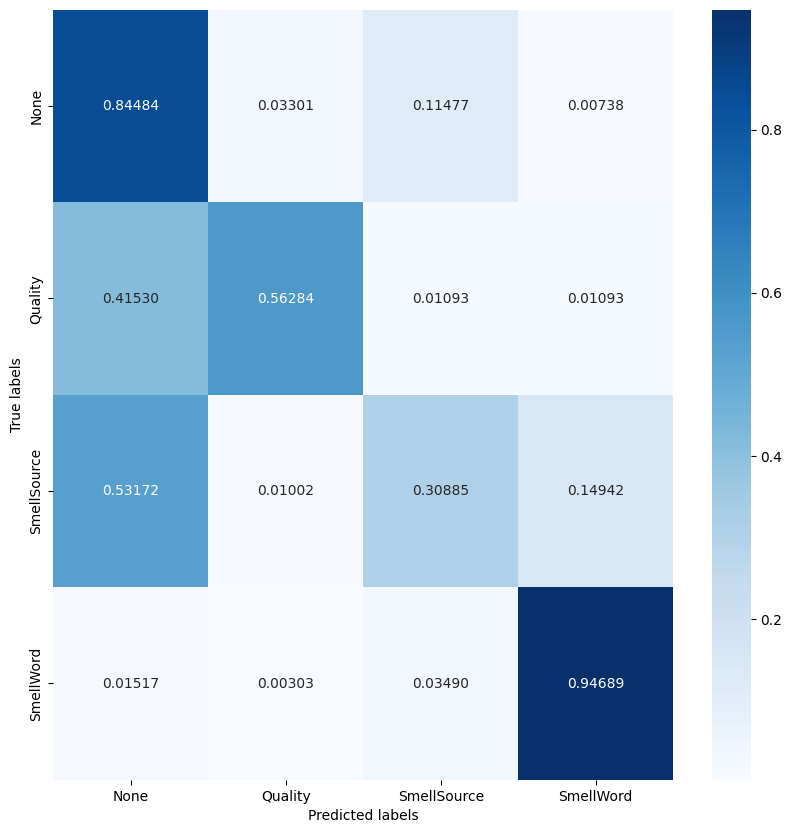

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Generate predictions
predictions = model.predict(inputs['input_ids'])
predicted_labels = np.argmax(predictions, axis=2)

# Flatten the predictions and true labels
predicted_labels_flat = predicted_labels.flatten()
labels_flat = labels.numpy().flatten()

# Print classification report with 5 decimal places
print(classification_report(labels_flat, predicted_labels_flat, target_names=le.classes_, digits=5))

# Compute the confusion matrix
cm = confusion_matrix(labels_flat, predicted_labels_flat, labels=np.unique(labels_flat))

# Normalize the confusion matrix for displaying ratio of each predicted class within its true class
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Display the confusion matrix with 5 decimal places
plt.figure(figsize=(10,10))
sns.heatmap(cm_norm, annot=True, fmt='.5f', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## **RoBERTa Large**

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from transformers import RobertaTokenizer, TFRobertaModel
import tensorflow as tf
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, TimeDistributed
from transformers import TFRobertaModel, RobertaConfig

# Load the configuration from file
config = RobertaConfig.from_pretrained('/content/drive/My Drive/roberta_large_bilstm_multilabel_uncased/roberta_config.json')

# Define the input shape
input_shape = (MAX_LEN,)  # Adjust according to your needs

# Create the RoBERTa model
input_layer = Input(shape=input_shape, dtype='int32')
roberta_output = TFRobertaModel(config)(input_layer)[0]

# Add the rest of the layers
lstm_layer = Bidirectional(LSTM(units=512, return_sequences=True))(roberta_output)
output_layer = TimeDistributed(Dense(4, activation='softmax'))(lstm_layer)  # replace num_labels with actual number

# Model building
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Load the weights from file
model.load_weights('/content/drive/My Drive/roberta_large_bilstm_multilabel_uncased/model_weights.h5')

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-large', do_lower_case=True)

# Assume you have a pandas DataFrame 'df_new' that contains your new data
sentences = df_new['token'].values

# Create a label encoder
le = LabelEncoder()

# Fit the encoder and transform labels to integers
labels = le.fit_transform(df_new['TAGS'].values)

MAX_LEN = 24

# Function to encode labels
def encode_labels(labels, max_len):
    encoded_labels = []
    for label in labels:
        encoded_label = [label] * max_len  # Repeat the label for the length of the sentence
        encoded_label = encoded_label[:max_len]  # Truncate if necessary
        encoded_labels.append(encoded_label)
    return np.array(encoded_labels)

# Now you can tokenize the sentences
inputs = tokenizer(sentences.tolist(), padding='max_length', truncation=True, max_length=MAX_LEN, return_tensors='tf')

# Encode the labels
labels = encode_labels(labels, MAX_LEN)

# Convert labels into tensorflow tensors
labels = tf.constant(labels)

# Optimizer, loss, and metric
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Evaluate the model on the new dataset
evaluation = model.evaluate(inputs['input_ids'], labels)

print('Evaluation results: ', evaluation)

1742/1742 [==============================] - 92s 49ms/step - loss: 0.9167 - accuracy: 0.8207
Evaluation results:  [0.916658341884613, 0.8207104206085205]


1742/1742 [==============================] - 86s 46ms/step
              precision    recall  f1-score   support

        None    0.98434   0.83118   0.90130   1288608
     Quality    0.06144   0.56284   0.11078      4392
 SmellSource    0.05102   0.32154   0.08807     28752
   SmellWord    0.53427   0.94689   0.68310     15816

    accuracy                        0.82071   1337568
   macro avg    0.40777   0.66561   0.44581   1337568
weighted avg    0.95593   0.82071   0.87864   1337568



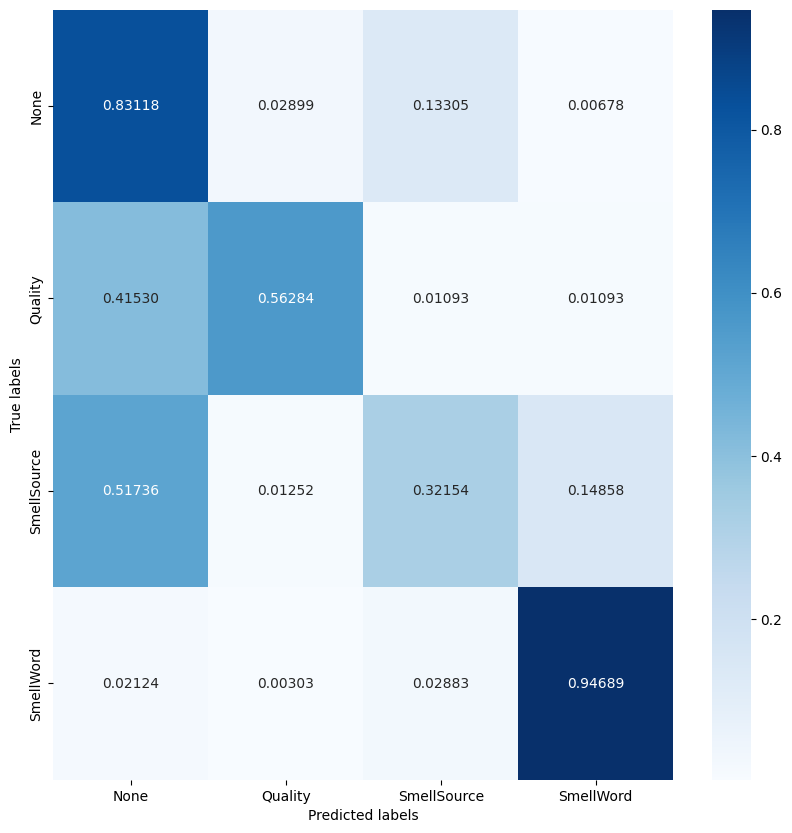

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Generate predictions
predictions = model.predict(inputs['input_ids'])
predicted_labels = np.argmax(predictions, axis=2)

# Flatten the predictions and true labels
predicted_labels_flat = predicted_labels.flatten()
labels_flat = labels.numpy().flatten()

# Print classification report with 5 decimal places
print(classification_report(labels_flat, predicted_labels_flat, target_names=le.classes_, digits=5))

# Compute the confusion matrix
cm = confusion_matrix(labels_flat, predicted_labels_flat, labels=np.unique(labels_flat))

# Normalize the confusion matrix for displaying ratio of each predicted class within its true class
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Display the confusion matrix with 5 decimal places
plt.figure(figsize=(10,10))
sns.heatmap(cm_norm, annot=True, fmt='.5f', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## **MacBERTh**

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertForTokenClassification
import tensorflow as tf
from google.colab import drive

# Load the tokenizer and the model
tokenizer = BertTokenizer.from_pretrained('emanjavacas/MacBERTh', do_lower_case=True)
model = TFBertForTokenClassification.from_pretrained('/content/drive/My Drive/macberth_multilabel_uncased/')

# Assume you have a pandas DataFrame 'df_new' that contains your new data
sentences = df_new['token'].values

# Create a label encoder
le = LabelEncoder()

# Fit the encoder and transform labels to integers
labels = le.fit_transform(df_new['TAGS'].values)

MAX_LEN = 24

# Encode the sentences to embeddings
input_ids = [tokenizer.encode(sent, add_special_tokens=True, max_length=MAX_LEN, padding='max_length', truncation=True) for sent in sentences]
input_ids = np.array(input_ids)

# Function to encode labels
def encode_labels(labels, max_len):
    encoded_labels = []
    for label in labels:
        encoded_label = [label] * max_len  # Repeat the label for the length of the sentence
        encoded_label = encoded_label[:max_len]  # Truncate if necessary
        encoded_labels.append(encoded_label)
    return np.array(encoded_labels)

# Encode the labels
labels = encode_labels(labels, MAX_LEN)

# Convert labels and inputs into tensorflow tensors
labels = tf.constant(labels)
inputs = tf.constant(input_ids)

# Optimizer, loss, and metric
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Evaluate the model on the new dataset
evaluation = model.evaluate(inputs, labels)

print('Evaluation results: ', evaluation)

Some layers from the model checkpoint at /content/drive/My Drive/macberth_multilabel_uncased/ were not used when initializing TFBertForTokenClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForTokenClassification were initialized from the model checkpoint at /content/drive/My Drive/macberth_multilabel_uncased/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForTokenClassification for predictions without further training.


1742/1742 [==============================] - 44s 23ms/step - loss: 0.8307 - accuracy: 0.7659
Evaluation results:  [0.8306979537010193, 0.7659199237823486]


1742/1742 [==============================] - 43s 23ms/step
              precision    recall  f1-score   support

        None    0.98358   0.77418   0.86641   1288608
     Quality    0.03316   0.57923   0.06272      4392
 SmellSource    0.04321   0.32231   0.07621     28752
   SmellWord    0.46832   0.95144   0.62768     15816

    accuracy                        0.76592   1337568
   macro avg    0.38207   0.65679   0.40825   1337568
weighted avg    0.95415   0.76592   0.84396   1337568



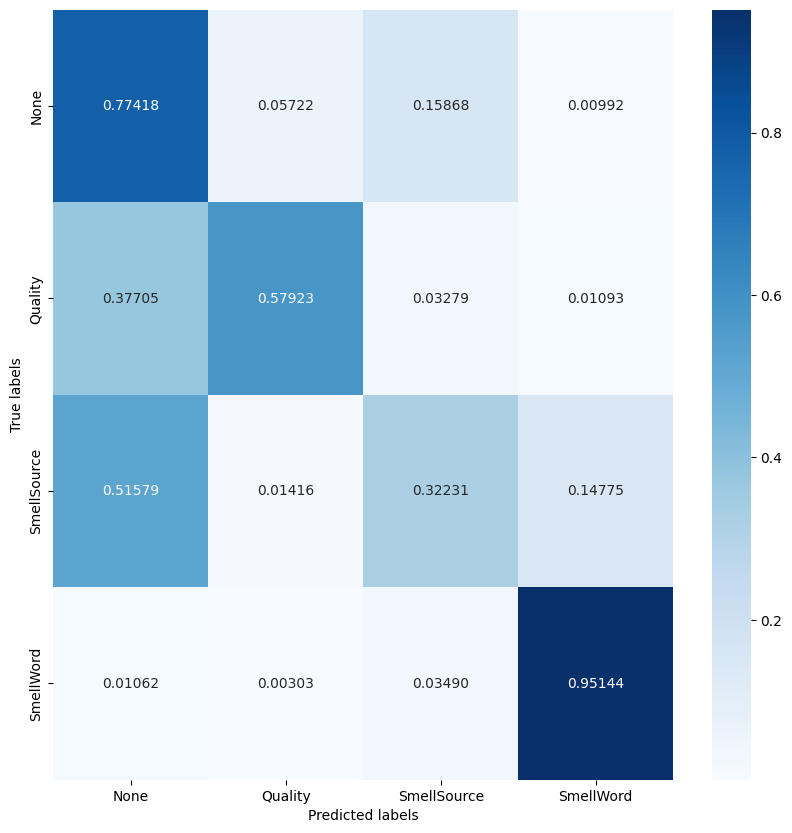

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Generate predictions
predictions = model.predict(inputs)['logits']
predicted_labels = np.argmax(predictions, axis=2)

# Flatten the predictions and true labels
predicted_labels_flat = predicted_labels.flatten()
labels_flat = labels.numpy().flatten()

# Print classification report with 5 decimal places
print(classification_report(labels_flat, predicted_labels_flat, target_names=le.classes_, digits=5))

# Compute the confusion matrix
cm = confusion_matrix(labels_flat, predicted_labels_flat, labels=np.unique(labels_flat))

# Normalize the confusion matrix for displaying ratio of each predicted class within its true class
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Display the confusion matrix with 5 decimal places
plt.figure(figsize=(10,10))
sns.heatmap(cm_norm, annot=True, fmt='.5f', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()